<a href="https://colab.research.google.com/github/wjtopp3/CSIT-2033/blob/main/Day2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

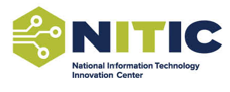

# Summer Working Connections May 2025
## Secure Programming with Python

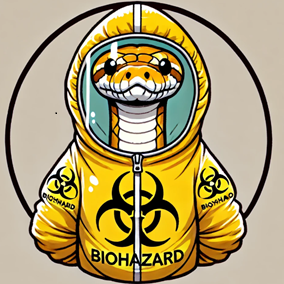

### Prof. Pamela Brauda and David Singletary
### Florida State College at Jacksonville

# Day 2: Data Science and AI
- Data Science Topics
- AI Topics


# Data Science Topics

1. Input Validation and Sanitization

2. Memory Management and Resource Control

3. Access Control and Data Privacy

4. Secure Data Storage and Serialization

5. Audit Logging and Error Handling

6. Third-Party Library and Dependency Management

# 1. Input Validation and Sanitization
- Ensure all data inputs (e.g., CSVs, JSON, user uploads) are validated before processing.

# 🛠️ Hands-On: Clean Data with Pandas Built-in Methods
- Use Pandas' built-in methods to check for missing values, unexpected types, or malformed rows.


In [ ]:
import pandas as pd

# input data
data = {
    "name": ["Alice", "Bob", None],
    "age": [25, "unknown", 30],
    "email": ["alice@example.com", "bob[at]example.com", "carol@example.com"]
}

df = pd.DataFrame(data)

# Check for missing values
if df.isnull().values.any():
    print("Warning: Missing values detected!")
    print(df.isnull().sum())

# Check for unexpected types (e.g., non-numeric ages)
if not pd.api.types.is_numeric_dtype(df['age']):
    print("Warning: Non-numeric values detected in 'age' column!")
    print(df['age'])

# Sanitize: Attempt to coerce 'age' to numeric, mark errors
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Check for malformed email addresses (basic check)
invalid_emails = df[~df['email'].str.contains(r"^[^@]+@[^@]+\.[^@]+$", regex=True)]
if not invalid_emails.empty:
    print("Warning: Malformed email addresses found!")
    print(invalid_emails['email'])

print("\nCleaned DataFrame:")
print(df)


# Prevent Malicious Payloads

- A code injection pattern is a sequence of input (e.g. Excel formulas or SQL statements) intended to insert malicious code into a program, aiming to trick the system into executing unintended commands, altering behavior, or compromising security.

# 🛠️ Hands-On: Sanitize Data
- Use string prefix checks to sanitize potentially dangerous spreadsheet formulas in a DataFrame.

In [ ]:
import pandas as pd

# uploaded data
data = {
    "username": ["alice", "bob", "=2+5", "+CMD|' /C calc'!A0"],
    "comment": ["hello", "world", "=HYPERLINK('http://malicious.com')", "goodbye"]
}

df = pd.DataFrame(data)

print("Original data:")
print(df)

# Sanitize dangerous formulas
dangerous_prefixes = ('=', '+', '-', '@')

def sanitize_formula(cell):
    if isinstance(cell, str) and cell.startswith(dangerous_prefixes):
        return "'" + cell
    return cell

# Apply sanitize_formula to each column separately
df_sanitized = df.copy()
for col in df_sanitized.columns:
    # map() applies a function to each element in a column
    df_sanitized[col] = df_sanitized[col].map(sanitize_formula)

print("\nSanitized data:")
print(df_sanitized)



# Sanitizing Data (cont)

- We can **vectorize** the previous example which would run faster for larger data sets using the Pandas applymap method:

```
    mask = df.applymap(lambda x: isinstance(x, str) and
                       x.startswith(dangerous_prefixes))
```

- This statement creates a boolean DataFrame (mask) where each cell is True if the original value is a string that starts with a dangerous prefix (such as =, +, -, or @), and False otherwise
  - **~mask** inverts the boolean mask: True becomes False and vice versa.
  - **"'" + df_sanitized** keeps the original values where the result is True, and replaces them with the sanitized value where it is False.

- (ignore the deprecation warning)

In [ ]:
import pandas as pd

# uploaded data
data = {
    "username": ["alice", "bob", "=2+5", "+CMD|' /C calc'!A0"],
    "comment": ["hello", "world", "=HYPERLINK('http://malicious.com')", "goodbye"]
}

df = pd.DataFrame(data)

print("Original data:")
print(df)

# Dangerous prefixes
dangerous_prefixes = ('=', '+', '-', '@')

# Vectorized function to sanitize entire DataFrame
# Create a boolean mask where cells need sanitization
mask = df.applymap(lambda x: isinstance(x, str) and x.startswith(dangerous_prefixes))

# Use np.where to efficiently sanitize
df_sanitized = df.copy()
df_sanitized = df_sanitized.where(~mask, "'" + df_sanitized)

print("\nSanitized data:")
print(df_sanitized)


# ==== Complete Day 2 Exercise 1 Here ====
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FSCJ-FacultyDev/SWC-Columbus-2025/blob/main/exercises/Day2Exercise1_Sanitizing_Input.ipynb)


# 2. Memory Management and Resource Control
- Management and Resource Control is a critical aspect of secure data processing when working with large datasets or user-supplied input.
- Loading entire files into memory at once can lead to excessive RAM usage, resulting in performance degradation or even crashing the application.
- In security-sensitive environments, such behavior may be exploited by attackers to trigger denial-of-service (DoS) attacks through resource exhaustion.
- A best practice is to use **chunked processing**, where data is read in manageable portions.
- **pandas.read_csv(..., chunksize=10000)** allows iteration over large files without fully loading them into memory.
### Memory Allocation
- Be mindful of memory allocation in numerical computations.
- Libraries like NumPy allow creation of very large arrays, which, if not properly constrained, can consume available memory or crash the interpreter. - Using array size limits, validating inputs, and preallocating memory only when necessary helps control memory footprint.
- Monitoring tools like Python's [tracemalloc](https://docs.python.org/3/library/tracemalloc.html) or [psutil](https://github.com/giampaolo/psutil) can be integrated into a pipeline to track memory usage during runtime and enforce thresholds.

# 🛠️ Hands-On: Chunked CSV Reading with Memory Usage Monitoring

In [ ]:
# create a large CSV file to test
import pandas as pd
import numpy as np

# Create a large DataFrame with 10,000,000 rows
num_rows = 10_000_000
data = {
    "id": range(num_rows),
    "value": np.random.rand(num_rows),
    "category": np.random.choice(["A", "B", "C", "D"], size=num_rows)
}

df = pd.DataFrame(data)

# Write to CSV
df.to_csv("large_dataset.csv", index=False)
print("large_dataset.csv created successfully.")

# Non-Chunked

In [ ]:
import pandas as pd
import psutil
import os
import time
import gc

print("NON-CHUNKED VERSION")

# create a Process object and monitor its memory and resource usage
process = psutil.Process(os.getpid())

start = time.time()
df = pd.read_csv("large_dataset.csv")
avg = df["value"].mean()
end = time.time()

mem_mb = process.memory_info().rss / (1024 ** 2)
print(f"Final average: {avg:.6f}")
print(f"Final memory: {mem_mb:.2f} MB")
print(f"Execution time: {end - start:.2f} seconds")

del df, avg
gc.collect()



# Chunked

In [ ]:
import pandas as pd
import psutil
import os
import gc
import time

print("CHUNKED VERSION (with accumulated average)")

process = psutil.Process(os.getpid())

chunk_iter = pd.read_csv("large_dataset.csv", chunksize=100000)

# Initialize accumulator variables
total_sum = 0.0
total_count = 0

start = time.time()
for i, chunk in enumerate(chunk_iter):
    chunk_sum = chunk["value"].sum()
    chunk_count = chunk["value"].count()

    total_sum += chunk_sum
    total_count += chunk_count

    del chunk, chunk_sum, chunk_count
    gc.collect()

end = time.time()

# Compute the final mean
final_avg = total_sum / total_count if total_count else 0

mem_mb = process.memory_info().rss / (1024 ** 2)
print(f"Final average: {final_avg:.6f}")
print(f"Final memory: {mem_mb:.2f} MB")
print(f"Execution time: {end - start:.2f} seconds")


# Chunking in a Nutshell
- Non-chunked reading is faster but can consume significantly more memory.
  - Risks crashes or DoS in memory-constrained environments.
- Chunked reading uses less memory, making it safer for large or untrusted files.
  - Introduces overhead due to repeated I/O and garbage collection.
  - Can be optimized by increasing chunk size and minimizing per-chunk overhead.

# 3. Access Control and Data Privacy
- Access control and data privacy come into play when  handling sensitive information, particularly in shared or multi-user environments.
- One effective control strategy is to enforce access policies through **row and column filtering**, which ensures that users can only view or manipulate the data they are authorized to access (similar to creating a view in a database).
- For example, an analyst might only be permitted to see records related to their assigned region (row-level filtering), or a customer support representative may be restricted from viewing personally identifiable information like social security numbers (column-level filtering).

# 🛠️ Hands-On: Use Column Filtering

In [ ]:
import pandas as pd

# Sample data
df = pd.DataFrame({
    'name': ['Alice', 'Bob', 'Carol'],
    'email': ['alice@example.com', 'bob@example.com', 'carol@example.com'],
    'ssn': ['123-45-6789', '987-65-4321', '555-55-5555'],
    'salary': [70000, 80000, 75000]
})

print("Original DataFrame:")
print(df)

# Only allow non-sensitive columns to be accessed
df_filtered = df[['name', 'email']]

print("\nFiltered DataFrame (restricted access):")
print(df_filtered)

# Anonymizing/Redacting Sensitive Fields
- Anonymizing and redacting sensitive fields is a key data privacy technique used to protect personally identifiable information (PII) or confidential attributes within a dataset.
- Anonymization typically involves transforming data so that individuals cannot be identified
  - This can include name hashing or email address masking
- Redaction replaces or removes sensitive values entirely (e.g., replacing a social security number with "***-**-****").
- These methods are used when sharing data with third parties, performing analytics, or creating datasets for testing or training machine learning models.

# 🛠️ Hands-On: Anonymize Sensitive Data in a Pandas DataFrame
- This program demonstrates how to anonymize sensitive fields in a DataFrame using pandas.
- It starts with a sample dataset containing personally identifiable information (PII) such as names, email addresses, and Social Security numbers.
- A copy of the original DataFrame is created, and the sensitive columns (name, email, and ssn) are overwritten with the placeholder value "REDACTED".
- This simple anonymization hides sensitive information while preserving the overall structure and non-sensitive data (like salary) for further analysis or sharing.

In [ ]:
import pandas as pd

# Sample data
df = pd.DataFrame({
    'name': ['Alice', 'Bob', 'Carol'],
    'email': ['alice@example.com', 'bob@example.com', 'carol@example.com'],
    'ssn': ['123-45-6789', '987-65-4321', '555-55-5555'],
    'salary': [70000, 80000, 75000]
})

print("Original DataFrame:")
print(df)

# Anonymize sensitive fields
df_anonymized = df.copy()
df_anonymized['name'] = 'REDACTED'
df_anonymized['email'] = 'REDACTED'
df_anonymized['ssn'] = 'REDACTED'

print("\nAnonymized DataFrame:")
print(df_anonymized)

# 🛠️ Hands-On: Masking Sensitive Fields

In [ ]:
import pandas as pd

# Sample data
df = pd.DataFrame({
    'name': ['Alice', 'Bob', 'Carol'],
    'email': ['alice@example.com', 'bob@example.com', 'carol@example.com'],
    'ssn': ['123-45-6789', '987-65-4321', '555-55-5555'],
    'salary': [70000, 80000, 75000]
})

print("Original DataFrame:")
print(df)

# Partially mask the SSN (show only last 4 digits)
df_masked = df.copy()
df_masked['ssn'] = df_masked['ssn'].apply(lambda x: "***-**-" + x[-4:])

print("\nPartially Masked DataFrame (SSN):")
print(df_masked)

# 4. Secure Data Storage and Serialization
- Choosing safe serialization methods and securing the storage are critical parts of building secure applications.
- The two processes are closely related because:
- Serialization is the process of converting data into a format (like JSON, pickle, XML) so it can be saved to storage or transmitted over a network.
- Secure data storage requires protecting the data both at rest (stored persistently and not actively being transmitted or processed) and during serialization to prevent unauthorized access, tampering, or exploitation.
- If serialization is handled insecurely, attackers can
  - Inject malicious payloads.
  - Read sensitive data from poorly protected files.
  - Exploit insecure formats (like untrusted pickle files) to execute arbitrary code.



# Avoid pickle
- pickle can execute arbitrary code when deserializing.
- Never load pickle files from untrusted sources.

```
# Pickle is unsafe
import pickle

# Dangerous: loading untrusted data
with open('user_data.pkl', 'rb') as f:
    data = pickle.load(f)  # Vulnerable to code execution
```


# JSON Serializes Securely
- JSON is data-only — it cannot embed executable code.
- It is better suited for secure storage and exchange of structured data.

```
# Using JSON for serialization
import json

# Safe: loading trusted JSON data
with open('user_data.json', 'r') as f:
    data = json.load(f)  # Parses data only, no code execution
```

# But JSON is Text - How Can It Be Secured?
- Sensitive data can be encrypted before writing it to storage.
- Always validate and sanitize data when loading from any serialized format.
- NOTE: Fernet encryption, provided by the cryptography library, is a Python-specific symmetric encryption method that securely encrypts data using a shared secret key. It is popular due to its simplicity, but is not suitable for large file encryption or streaming since it requires that the entire message reside in memory.
- We describe various cryptography libraries in the Day 3 content.

# 🛠️ Hands-On: Encrypt and Decrypt JSON Data
- This program uses Fernet symmetric encryption to demonstrates secure encryption and decryption of JSON data.
- It generates a key and saves it to a file, then creates a sample JSON object, serializes it to bytes, and encrypts it.
- The encrypted data is then saved to a binary file.
- The program then reads the key and encrypted data back from disk, validates that the encrypted file is not empty, and attempts to decrypt and parse the JSON securely.
- If decryption fails due to tampering or corruption, it raises an InvalidToken error.
- Finally, it prints the decrypted data and cleans up temporary files, ensuring confidentiality and integrity of the data at rest.

In [ ]:
from cryptography.fernet import Fernet, InvalidToken
import json
import os

# generate and save the encryption key securely
key = Fernet.generate_key()
with open('secret.key', 'wb') as key_file:
    key_file.write(key)

# create a cipher using the key
cipher = Fernet(key)

# create JSON data to encrypt
json_data = {
    "username": "admin",
    "password": "SuperSecret123!",
    "permissions": ["read", "write", "delete"]
}

# serialize JSON to string and then encode to bytes
json_string = json.dumps(json_data)
data_bytes = json_string.encode('utf-8')

# encrypt the serialized data
encrypted_data = cipher.encrypt(data_bytes)

# save the encrypted data to a file
with open('secure_data.bin', 'wb') as data_file:
    data_file.write(encrypted_data)

# reload the key (yes, we already have it) and encrypt the data

try:
    # load the key
    with open('secret.key', 'rb') as key_file:
        loaded_key = key_file.read()

    # recreate the cipher using the key
    loaded_cipher = Fernet(loaded_key)

    # load the encrypted data
    with open('secure_data.bin', 'rb') as data_file:
        encrypted_contents = data_file.read()

    # validate - Check if the file is empty
    if not encrypted_contents:
        raise ValueError("Error: Encrypted file is empty.")

    # attempt decryption (sanitize - verify integrity)
    decrypted_bytes = loaded_cipher.decrypt(encrypted_contents)

    # decode bytes back to string and parse JSON
    decrypted_json = json.loads(decrypted_bytes.decode('utf-8'))

    # use the clean decrypted JSON data
    print("Decrypted JSON data:")
    print(json.dumps(decrypted_json, indent=2))

except InvalidToken:
    print("Error: Decryption failed — data may have been tampered with!")
except Exception as e:
    print(f"Unexpected error: {e}")

# clean up files after demonstration
os.remove('secure_data.bin')
os.remove('secret.key')


# 5. Audit Logging and Error Handling
## Audit Logging
- Effective audit logging is a fundamental practice in secure software development.
  - Audit logs serve as a record of significant system events, particularly those involving access to or modification of sensitive data. These logs are invaluable for identifying unauthorized behavior, debugging critical issues, and maintaining regulatory compliance.
  - In Python, audit logging can be implemented using the built-in logging module or more advanced frameworks such as structlog or loguru (See Day 1), which support structured and context-rich output.
- To ensure reliability, audit logs should be written to immutable, access-controlled storage with timestamps and user identifiers where applicable.
  - A best practice is to use structured logging, which encodes log entries in a machine-readable format such as JSON.
  - Structured logs make it easier to analyze large volumes of events using tools like [ELK Stack](https://www.elastic.co/elastic-stack) or [Splunk](https://www.splunk.com/).
  - Rather than outputting raw strings, logs can include fields like event_type, user_id, timestamp, and operation_status.
  - This avoids exposing sensitive application data or internal stack traces, which could otherwise be exploited if logs are improperly accessed.


# 🛠️ Hands-On: Audit Logging using JSON

In [ ]:
import logging
import json

# set up the logger object
logger = logging.getLogger("audit")
logger.setLevel(logging.INFO)
handler = logging.FileHandler("audit.log")
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

# this function creates the JSON format of the entry
def log_event(user_id, action, status):
    log_entry = {
        "user_id": user_id,
        "action": action,
        "status": status
    }
    logger.info(json.dumps(log_entry))

#call the function with sample data
log_event("user123", "data_export", "success")


## Error Handling
- Effective Error Handling is another fundamental practice of secure software development.
  - Error handling should be implemented to catch exceptions without revealing system internals or sensitive data.
  - When exceptions occur, error messages should be logged in a controlled and sanitized way, avoiding the exposure of stack traces or database query details.
  - Instead of displaying raw exceptions to users or recording them verbatim in logs, the application should issue generic (but useful) messages and retain detailed logs for administrators only.


# 🛠️ Hands-On: Safe Error Handling Using JSON

In [ ]:
import logging
import json

# set up the logger object
logger = logging.getLogger("audit")
logger.setLevel(logging.INFO)
handler = logging.FileHandler("audit.log")
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

# a simple function to test error handling
def divide(a, b):
    try:
        return a / b
    except ZeroDivisionError:
        logger.error(json.dumps({
            "error": "Attempted division by zero",
            "operation": "divide",
            "inputs": {"a": a, "b": b}
        }))
        return "Division by zero is not allowed."

# function calls to test error handling
print(divide(12, 2))
print(divide(12, 0))

#### A NOTE about the output of these two function calls:
```
ERROR:audit:{"error": "Attempted division by zero", "operation": "divide", "inputs": {"a": 12, "b": 0}}
The quotient is 6.0
'Division by zero is not allowed.'
```
- The output may contain the **ERROR:audit:** message before the output of the print statement, even though the print function is called before the error occurs.
- This is because the output from logger.error is sent to stderr and the output of the print statement on line 15 is sent to stdout.
- Notebooks like Jupyter and Colab prioritize stderr and buffer stdout, so the ERROR message may appear before the output.







# Integrating External Tools for Secure and Structured Logging
- Consider integrating external tools or frameworks to enforce best practices.
  - Libraries like [structlog](https://www.structlog.org/en/stable/) support event-based structured logging and context management
  - Services like [Sentry](https://sentry.io/for/python) or [Datadog](https://www.datadoghq.com) provide real-time error monitoring and alerting.
- Logging libraries should always be configured to mask or exclude sensitive fields (e.g., passwords, personal identifiers) before serialization.
- Access to audit logs should be restricted to authorized personnel to prevent abuse.
- Combining secure audit logging with structured logging and disciplined error handling provides greater resilience, maintainability, and compliance with standards such as HIPAA and GDPR.

# ==== Complete Day 2 Exercise 2 Here ====
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FSCJ-FacultyDev/SWC-Columbus-2025/blob/main/exercises/Day2Exercise2_StructuredLogging.ipynb)


# 6. Third-Party Library and Dependency Management

- Third-Party Library and Dependency Management is a critical aspect of Python software development that ensures applications are built using reliable, secure, and maintainable external packages.
  - Python's ecosystem boasts a vast array of third-party libraries available through the Python Package Index (PyPI), offering developers access to prebuilt functionality for tasks like web development, machine learning, data analysis, and cryptography.
  - Relying on external packages introduces risks such as compatibility issues, deprecated APIs, or vulnerabilities.
  - Proper dependency management practices help mitigate these risks and maintain the long-term health of a project.
    - Keep dependencies up to date by patching known vulnerabilities.
    - Use virtual environments or containers to isolate packages.
    - Verify the integrity of libraries (e.g., via hash checks or using trusted sources like PyPI).
- The most common tool for managing Python dependencies is pip, which allows developers to install packages using simple commands like *pip install requests*.
- To ensure consistency across development environments, dependencies are often listed in a requirements.txt file. This file serves as a manifest of exact versions used in a project and can be regenerated using pip freeze > requirements.txt.

In [ ]:
# Use the ! to run shell commands
!pip install requests flask
!pip freeze > requirements.txt

    - Example of a requirements.txt file:

        flask==2.3.2  
        requests==2.31.0  

    - NOTE: The rest of the packages that are required by flask or requests either already exist or are downloaded and installed.



- Using virtual environments or containers like Docker ensures that dependencies are isolated, reproducible, and avoid polluting the global environment.
  - Isolation enhances security by creating controlled, predictable environments and limiting exposure to global Python environments or system-wide packages.
  - Reproducibility is especially important in teams or production deployments.
  - Python developers frequently use tools like venv or virtualenv.
  - These tools create project-specific environments where dependencies can be installed without conflicting with those of other projects.

### The following is sample code only, it is not intended to be run in Colab
  
```
# Create a virtual environment using the venv command
# (the following code is intended to run on Linux)
# Name the virtual environment venv -- to make sure it's confusing for beginners
python -m venv venv

# Activate the virtual environment
source venv/bin/activate  # On Windows: venv\Scripts\activate

# Install the specific packages required from the requirements.txt file
pip install -r requirements.txt

# This is also a fun demo using the command prompt with Python installed
```  

- For larger projects or those requiring more sophisticated workflows, tools like Poetry or Pipenv offer enhanced dependency resolution, semantic versioning, and lock file generation.
  - These tools help manage both direct and transitive dependencies more precisely.
  - Integrating security tools such as pip-audit or GitHub's Dependabot helps identify known vulnerabilities in third-party packages, enabling proactive patching.
- The following code uses pip-audit to audit your project's dependencies:

In [ ]:
!pip install pip-audit
!pip-audit

# This is another demo that is better using a command prompt on your machine
# instead of using Colab

  - Keeping data science libraries like NumPy and Pandas up to date is crucial:
    - patching security vulnerabilities
    - improving performance
    - ensuring compatibility with other modern libraries.
  - Outdated packages can expose applications to known security issues that are publicly documented in CVEs (Common Vulnerabilities and Exposures).
  - Tools like pip list --outdated, pip-review, or automated scanners such as GitHub Dependabot can help identify outdated packages.


In [ ]:
# Use pip to check for outdated packages
!pip list --outdated

  - Running the above code block may reveal some 'outdated' packages
  - Sometimes the latest is not always the greatest
    - The newest version of a package may not be compatible with other stable packages being used.

- Verifying the integrity of libraries helps ensure a malicious or tampered package is not installed.
  - Python supports hash checking mode via pip, which uses SHA256 hashes in requirements.txt to verify the exact files being installed.

In [ ]:
!pip download numpy==2.2.5
!pip hash /content/numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

- We can now add this information to our requirements.txt file:

```
numpy==2.2.5 \
  --hash=sha256:d84a1e9a5f2b4fadc3e9a2f8a69dfae9d048ba861b546f5e4f3a4a0b7a65c208
```

- Including a --hash with each dependency ensures the exact package file is used.
- If someone uploads a malicious version of numpy==2.2.5 to PyPI, or if a mirror is compromised, pip will refuse to install it if the file’s SHA256 hash doesn’t match.
- This protects development and deployment pipelines from executing compromised code during automated builds or deployments.

# Best Practices
By following best practices in dependency management such as pinning versions, isolating environments, regularly auditing packages, and avoiding unmaintained libraries, developers can reduce technical debt and enhance the reliability and security of Python applications.

# NOTE from "Alice and Bob Learn Secure Coding":
[2] Janca, Ch. 6
"You might have noticed that I suggested Pip Freeze and then said not to pin your libraries. How can you both freeze and keep updating libraries? Whenever you have a chance to do a code update, you want to update as many libraries as you can, to avoid technical debt. If you have the libraries pinned, they won't do that. But when you move from environment to environment (dev ‐> QA ‐> staging), you do not want versions of your code changing, as your testing will be inaccurate. Once you are ready to go beyond dev, you freeze, but before that, you update, update, update (especially libraries!)."

# AI Topics
1. Using AI Safely and Securely
2. Ethical Use of AI
3. Data Integrity
4. Defending Against Adversarial Attacks
5. Secure Model Deployment and Monitoring

# 1. Using Artificial Intelligence Safely and Securely

- As artificial intelligence becomes increasingly integrated into software development workflows, developers must focus on safety and security.
  - [**Safety**](https://arxiv.org/pdf/1606.06565) protects the system and its users from unintentional harm.
  - This includes preventing software bugs, ensuring system reliability, avoiding accidents (e.g., crashing an autonomous system), and mitigating unintended consequences of AI behavior.
  - Safety is about making sure the system does what it's supposed to do, and doesn’t do something dangerous by mistake.
  - [**Security**](https://arxiv.org/pdf/1802.07228) focuses on protecting the system from intentional harm, such as malicious attacks, unauthorized access, data breaches, or exploitation of vulnerabilities.
  - It's about defending against external threats and ensuring confidentiality, integrity, and availability.
- Tools such as code assistants, vulnerability scanners, and automated reasoning engines can help identify bugs, enforce secure coding standards, and streamline threat modeling.
- Use caution when relying on AI-generated code, as it may introduce vulnerabilities or insecure results from training data.

# Useful Tips from Alice and Bob
[2] Ch. 15

- Use AI to write user stories, documentation, and anything else that is written for your job.
  - Double‐check everything before showing it to anyone else; the first draft will likely be imperfect.
- Use AI to help you write code; just make sure you check it first and don't give it sensitive data when asking for that help.
- Use AI to help you find vulnerabilities; if you can share your code (e.g., open source), ask it to find vulnerabilities.
  - It might not be as good as a SAST tool, but if you have an AI and you don't have a SAST tool, take what you can get.
- Ask AI to do threat models for you; you will likely come up with lots of ridiculous ideas, but it usually has one or two good ones.
- Ask AI for help with design, describe what you want, and see what it comes up with.
  - This is like asking a junior employee: the ideas can be a bit wacky, but you get a lot of results really fast, and some of it is usable.
- Ask AI to add comments to your code.
  - It might be able to add more than you would have the patience for.
  - Be sure they are kept concise and brief; no one wants to read a novel.
- Ask AI to suggest bug fixes; some of them will be good.

# Caveats:
- Do not allow AI to make decisions on behalf of applications without oversight
  - Each decision should have some other part of the code not controlled by the AI validate the decision
  - AI should never be trusted to make an important decision on its own
- An AI should not be able to control itself or others
  - Many current researchers cannot fully explain how models work or why they hallucinate
- Do not share sensitive or private information with an AI unless you own or control it
- Always fully review AI-generated code
  - Don't use it if you don't understand how it works
  - [Junior developers sometimes rely too heavily on them without fully understanding the code being created](https://www.calcalistech.com/ctechnews/article/ybba8gx5n)
  - [As a junior developer, it’s important to learn the fundamentals](https://noncodersuccess.medium.com/should-junior-developers-use-ai-for-coding-24cc03717525)
- Verify AI-generated content has not broken copyright
  - Be sure it is original, properly attributed, and not derived from protected material.

# 2. Ethical Use of AI
## How Does AI Ethics Relate to Secure Development?
1. Bias as a Security Risk
	- Biased models can lead to unfair treatment (e.g., in hiring or lending).
	- Security tie-in: Attackers can exploit known biases to game or manipulate models (e.g., feeding crafted inputs to skew recommendations).
2. Data Privacy and Confidentiality
	- Users have a right to privacy; exposing sensitive data violates ethical standards.
	- Security tie-in: Poor privacy protections can lead to data leaks or model inversion attacks that reconstruct private training data.
3. Accountability and Transparency
	- Users should know how decisions are made and be able to challenge them.
	- Security tie-in: Transparent systems allow for better auditing, threat detection, and accountability for model behavior and access.
4. Adversarial Robustness as Ethical Responsibility
	- Systems should behave reliably and safely, especially in critical domains like healthcare or autonomous driving.
	- Security tie-in: Building defenses against adversarial attacks ensures models cannot be tricked into unsafe or harmful outputs.
5. Fair Access and System Abuse
	- AI systems should not reinforce inequality or exclusion.
	- Security tie-in: Rate limiting, authentication, and abuse detection protect systems from being exploited for unfair advantage.

# Compliance with Legal and Regulatory Requirements
- Compliance guidelines such as the General Data Protection Regulation (GDPR) and U.S. Equal Employment Opportunity Commission (EEOC) is essential.
- These regulations mandate responsible data handling, privacy protections, and fairness in areas like automated decision-making, user profiling, and employment screening.
- Developers must ensure that AI-driven applications are transparent, auditable, and designed to avoid bias or discrimination
- Robust security is required to protect sensitive data.
- Proper data validation, encryption, access control, and audit logging play a critical role.


5. Secure Model Deployment
- Restrict access to inference endpoints and model files.
	- Authenticate and authorize API requests to prevent abuse or reverse engineering.
	- Protect models in memory and at rest using encryption and secure containers.
6. Privacy-Preserving Machine Learning
- Implement techniques like differential privacy, federated learning, or homomorphic encryption.
	- Mask or anonymize sensitive features during preprocessing.
	- Ensure compliance with data minimization principles.
7. Monitoring and Incident Response
- Continuously monitor model behavior for drift, misuse, or attacks.
	- Set up logging and alerting systems for unexpected input/output patterns.
	- Have a rollback or patching process in place for compromised models.

# 3. Data Integrity

- Maintaining data integrity is fundamental to the development of secure and reliable AI systems, beginning with validating and cleaning training data to detect anomalies, outliers, or potentially malicious inserts that could impact model behavior or introduce vulnerabilities.
- In traditional software development, we only need to focus on testing and versioning code. [6] Ch. 1  
- In machine learning, we have to test and version our data as well
- Indiscriminately accepting all available data might hurt your model’s performance and even make it susceptible to data poisoning attacks
- High-quality, trusted data input is essential to reduce the risk.
- Basic strategies for regularly auditing models for signs of weak performance can help, as well as using advanced measures such as [defensive distillation](https://arxiv.org/pdf/1511.04508) and [feature squeezing](https://arxiv.org/pdf/1704.01155).
- [Cisco: How to detect and mitigate AI data poisoning](https://outshift.cisco.com/blog/ai-data-poisoning-detect-mitigate)
- Implementing data versioning and **provenance tracking** (keeping a record of data origin, changes, and history) allows developers to trace the origin, transformations, and usage of datasets over time.
- MLOps frameworks like [DVC (Data Version Control)](https://dvc.org/doc) provide built-in support for versioning and provenance tracking.
- Reproducibility, accountability, and rollback are essential to handle potential contamination or error.
- Data validation libraries, logging pipelines, and checksum verification help enforce these safeguards.

# 🛠️ Hands-On: Detect Model Poisoning Using IsolationForest
- Detecting outliers using Scikit-Learn's IsolationForest algorithm can flag potentially poisoned samples during preprocessing.
- IsolationForest detects outliers by repeatedly splitting data to see which points are easiest to isolate.
- IsolationForest.fit_predict() labels each data point as either:
  - 1 → inlier (normal)
  - -1 → outlier (anomalous / possible poisoned sample)

![IsolationForest](https://raw.githubusercontent.com/FSCJ-FacultyDev/SWC-Columbus-2025/main/images/day2-isolationforest.png)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest

# Simulate training data with potential poisoned samples
np.random.seed(42)

# Generate 100 data points with 2 features from a normal distribution
#   ~68% within ±1 standard deviation (i.e., between −1 and 1)
#   ~95% within ±2 standard deviations (i.e., between −2 and 2)
#   ~99.7% within ±3 standard deviations (i.e., between −3 and 3)
normal_data = np.random.normal(loc=0.0, scale=1.0, size=(100, 2))

# Manually create 2 outliers to simulate poisoned samples
poisoned_data = np.array([[10, 10], [15, -12]])  # Simulated poisoned outliers

# Stack the normal and poisoned data vertically to form one dataset
data = np.vstack((normal_data, poisoned_data))

# Convert to DataFrame for inspection
df = pd.DataFrame(data, columns=["feature1", "feature2"])

# Apply Isolation Forest to detect outliers
# (relative to this specific dataset)
model = IsolationForest(contamination=0.05)
df['anomaly'] = model.fit_predict(df[["feature1", "feature2"]])

# -1 indicates an outlier (possible poisoned sample)
outliers = df[df['anomaly'] == -1]
clean_data = df[df['anomaly'] == 1]

print("Detected Outliers (Possible Poisoned Samples):")
print(outliers)

# 4. Defending Against Adversarial Attacks
- **Adversarial attacks** involve subtly modified inputs designed to fool machine learning models into making incorrect predictions.
- These are often imperceptible to humans but can drastically alter model outputs, revealing vulnerabilities in both the model and the broader software systems that depend on its predictions.
- **Adversarial training** is a widely adopted technique which involves augmenting the training dataset with adversarial examples so that the model learns to classify both normal and adversarial inputs correctly.
  - This helps prepare the model for real-world attacks by simulating them during training.
- **Input regularization techniques**, such as adding noise or using dropout, further harden models by discouraging overfitting and encouraging the model to generalize better, reducing its sensitivity to small variations.
- Detection mechanisms can also be used at inference time to identify and reject potentially adversarial inputs.
  - These might involve monitoring for abnormal activation patterns (i.e., inputs that trigger unexpected neuron activation responses) or statistical flags that suggest input manipulation.
- Evaluating model robustness can be performed using specialized testing frameworks like [CleverHans](https://cleverhans.io/) and [Foolbox](https://foolbox.readthedocs.io/en/stable/#) which generate adversarial examples and assess model susceptibility.
- These tools support continuous security testing practices similar to **fuzzing** (feeding a program  large volumes of unexpected or random data to discover  vulnerabilities, crashes, or unexpected behavior) and penetration testing in traditional software.

# 🛠️ Hands-On: Add Noise to Training Data

In [ ]:
# adding noise for input regularization

import numpy as np

# Original input (e.g., a vector representing an image or features)
original_input = np.array([0.5, 0.7, 0.2, 0.9])

# Add Gaussian noise with mean 0 and standard deviation 0.1
noise = np.random.normal(loc=0.0, scale=0.1, size=original_input.shape)
noisy_input = original_input + noise

print("Original input:", original_input)
print("Noisy input:   ", noisy_input)

In [ ]:
# Deep learning example: apply Gaussian noise during training for robustness

import numpy as np
from tensorflow.keras.layers import Input, Dense, GaussianNoise
from tensorflow.keras.models import Model

# Define the input layer with 4 features
inputs = Input(shape=(4,))

# Apply Gaussian noise (stddev = 0.1) to the input during training
# Regularizes the model by making it less sensitive to small input changes
x = GaussianNoise(0.1)(inputs)

# Add a hidden dense layer with 16 neurons and ReLU activation
x = Dense(16, activation='relu')(x)

# Output layer with 1 neuron and sigmoid activation
# (suitable for binary classification)
outputs = Dense(1, activation='sigmoid')(x)

# Build the model
model = Model(inputs, outputs)

# Compile the model with Adam optimizer and binary crossentropy loss function
model.compile(optimizer='adam', loss='binary_crossentropy')

# Sample batch of input data (3 samples with 4 features each)
sample_input = np.array([
    [0.5, 0.7, 0.2, 0.9],
    [0.1, 0.3, 0.5, 0.2],
    [0.9, 0.8, 0.1, 0.4]
])

# Perform a forward pass in training mode (noise is applied)
predictions_with_noise = model(sample_input, training=True)

# Perform a forward pass in inference mode (no noise applied)
predictions_without_noise = model(sample_input, training=False)

# Compare model predictions with and without input noise
print("Predictions with noise:\n", predictions_with_noise.numpy())
print("\nPredictions without noise:\n", predictions_without_noise.numpy())

# Summary of results
- The predictions with noise are close to but not exactly the same as those without noise.
- The differences are generally small if the model is reasonably well-behaved and the standard deviation of the noise is low (0.1).
- This difference illustrates the effect of input noise and how the model responds to slight variations in input values.
- This technique helps in:
  - Preventing overfitting by exposing the model to slightly altered data during training.
  - Improving generalization to real-world data that may contain natural variability or noise.
  - Making the model more robust against adversarial examples or unintended edge-case inputs.
  - Enhancing resilience to input fuzzing and injection attacks, which is a valuable defensive measure.

# 5. Secure Model Deployment
- Securely deploying machine learning models is critical in environments where privacy, intellectual property, or safety is at stake.
- Unlike traditional software, machine learning models can be reverse-engineered or exploited in subtle ways, including model extraction attacks or unauthorized use of prediction APIs.
- Deploying an AI model securely means more than serving it efficiently; it requires restricted access, hardened infrastructure, and strict interaction controls.
- A decision must also be made of where computation will happen: in the cloud, on-premises, or at the edge—each with trade-offs in performance, privacy, and security.
- One of the most effective strategies is to restrict access to inference endpoints and model files [8]  
- In practice, this means hosting APIs behind a firewall, limiting network access with IP allowlists or VPNs, and storing model artifacts (like .pkl or .pt files) in protected locations with limited read access
- For containerized deployments, models can be stored inside secure Docker images with reduced permissions, ensuring that even if a container is compromised, the model cannot be easily exfiltrated.
- To prevent abuse, authentication and authorization mechanisms should be applied to every request, including API keys, OAuth tokens, or TLS certificates.
- Rate limiting and anomaly detection can help identify and stop brute-force or scraping attempts, while request logging provides an audit trail to monitor access patterns.
- Additionally, compiled model representations (e.g., [ONNX](https://docs.nvidia.com/deeplearning/tensorrt/latest/architecture/architecture-overview.html#onnx)) makes it harder for attackers to reverse-engineer model internals.
  - ONNX, as an open standard, doesn't necessarily add much to the security, but additional actions can be taken such as obfuscating the model, disallowing direct access through APIs, encrypting it at rest, and using secure enclaves (see below).
- Protecting models both in memory and at rest is essential to avoid leakage or tampering.
- At rest, models should be encrypted using strong AES-based schemes, and stored in secure storage solutions like AWS KMS-integrated S3 buckets or encrypted volumes.
- In memory, using secure enclaves (protected regions of memory) (e.g., [Intel SGX](https://www.intel.com/content/www/us/en/products/docs/accelerator-engines/software-guard-extensions.html)) can shield inference computations from the rest of the system.
- Secure containers (e.g., an [AppArmor-enabled Docker image](https://docs.docker.com/engine/security/apparmor/)) and runtime sandboxes (like [gVisor](https://gvisor.dev/)) make sure a model operates within an isolated environment with limited system privileges.

# 🛠️ Hands-On: Obfuscate a Model

In [ ]:
!pip install torch torchvision onnx onnxruntime onnxsim netron

In [ ]:
# create a simple Pytorch model and export to ONNX

import torch
import torch.nn as nn
import onnx

# define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        return self.fc(x)

# instantiate and export to ONNX
model = SimpleModel()
dummy_input = torch.randn(1, 4)  # batch size 1, input size 4

onnx_path = "simple_model.onnx"
torch.onnx.export(model, dummy_input, onnx_path,
                  input_names=["input"], output_names=["output"],
                  opset_version=11)

print(f"Model exported to {onnx_path}")


In [ ]:
# plot the model from the ONNX data

!pip install pydot graphviz

import onnx
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
from IPython.display import Image, display

model = onnx.load(onnx_path)
pydot_graph = GetPydotGraph(model.graph, name=model.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("all"))
pydot_graph.write_png("onnx_model.png")

# Display the image
display(Image(filename="onnx_model.png"))


In [ ]:
import onnx

# Load the ONNX model
model = onnx.load("simple_model.onnx")

# obfuscate node names: hides layer-level semantics (e.g., 'fc1', 'relu')
# by replacing them with generic identifiers
for i, node in enumerate(model.graph.node):
    node.name = f"node_{i}"
    # Obfuscate input and output names per node: rename data flow tensors
    # to mask data dependencies and internal structure
    node.input[:] = [f"in_{i}_{j}" for j in range(len(node.input))]
    node.output[:] = [f"out_{i}_{j}" for j in range(len(node.output))]

# obfuscate graph-level input names: remove meaningful label names
# from the model’s entry points
for i, inp in enumerate(model.graph.input):
    inp.name = f"input_{i}"

# obfuscate output names: prevents revealing the target or
# prediction type (e.g., "output", "logits", "probabilities")
for i, out in enumerate(model.graph.output):
    out.name = f"output_{i}"

# obfuscate initializer names (e.g., weights and biases): masks learned
# parameters so attackers cannot easily trace them to specific layers
for i, init in enumerate(model.graph.initializer):
    init.name = f"param_{i}"

# save the obfuscated model
onnx.save(model, "simple_model_obfuscated.onnx")
print("obfuscated model saved as simple_model_obfuscated.onnx")


In [ ]:
# plot the obfuscated model

# layer and parameter names have been replaced with generic identifiers,
# making the model less interpretable to humans and resistant to casual
# casual inspection and basic reverse engineering.

# does not protect model weights or prevent functional analysis.

import onnx
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
from IPython.display import Image, display

onnx_path = "simple_model_obfuscated.onnx"

model = onnx.load(onnx_path)
pydot_graph = GetPydotGraph(model.graph, name=model.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("all"))
pydot_graph.write_png("onnx_model.png")

# Display the image
display(Image(filename="onnx_model.png"))
